In [1]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
from tqdm import tqdm
import glob
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress

In [2]:
files = glob.glob('../BL_Work/openPrescribe/savings/*.h5')
files.sort()
print files

['../BL_Work/openPrescribe/savings/201008.h5', '../BL_Work/openPrescribe/savings/201009.h5', '../BL_Work/openPrescribe/savings/201010.h5', '../BL_Work/openPrescribe/savings/201011.h5', '../BL_Work/openPrescribe/savings/201012.h5', '../BL_Work/openPrescribe/savings/201101.h5', '../BL_Work/openPrescribe/savings/201102.h5', '../BL_Work/openPrescribe/savings/201103.h5', '../BL_Work/openPrescribe/savings/201104.h5', '../BL_Work/openPrescribe/savings/201105.h5', '../BL_Work/openPrescribe/savings/201106.h5', '../BL_Work/openPrescribe/savings/201107.h5', '../BL_Work/openPrescribe/savings/201108.h5', '../BL_Work/openPrescribe/savings/201109.h5', '../BL_Work/openPrescribe/savings/201110.h5', '../BL_Work/openPrescribe/savings/201111.h5', '../BL_Work/openPrescribe/savings/201112.h5', '../BL_Work/openPrescribe/savings/201201.h5', '../BL_Work/openPrescribe/savings/201202.h5', '../BL_Work/openPrescribe/savings/201203.h5', '../BL_Work/openPrescribe/savings/201204.h5', '../BL_Work/openPrescribe/savings

In [4]:
pdp = pd.read_hdf(files[0])

In [5]:
# %store -r opiod_BNF
%store -r antiDep_BNF

In [6]:
opiod_BNF = antiDep_BNF

In [7]:
LSOA_dist = json.load(open('GP_LSOA_PATIENTSDIST.json','rb'))

In [8]:
opiod_BNF.head()

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
285,285,0204000P0,Pindolol ...,BJ4HF6IU1D
295,295,020400010,Pindolol With Diuretic ...,BJ4HF6IU1D
673,673,0305010W0,Doxapram Hydrochloride ...,94F3830Q73
765,765,0401020B0,Buspirone Hydrochloride ...,TK65WKS8HL
767,767,0401020D0,Chlordiazepoxide ...,6RZ6XEZ3CR


In [9]:
ward_pop = pd.read_csv('ward_pop.csv')

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
GP_META = pd.read_csv('../BL_Work/epraccur.csv',header=None)
GP_META.rename(columns={0:'BP_code',
                        1:'Name',
                        2:'Grouping',
                        3:'National_geo',
                        4:'Addr1',
                        5:'Addr2',
                        6:'Addr3',
                        7: 'Addr4',
                        8:'Addr5',
                        9:'Postcode',
                        10:'Open',
                        11:'Closed',
                        12:'Status',
                        13:'Org type code',
                        14:'Commissioner',
                        15:'Join provider',
                        16:'Left provider',
                        17:'Contact',
                        18:'Null1',
                        19:'Null2',
                        20:'Null3',
                        21:'Amended',
                        22:'Null4',
                        23:'Provider',
                        24:'Null5',
                        25:'Setting',
                        26:'Null6'}, 
                 inplace=True)

In [11]:
Open_filtered_GPs = {}
for index,row in GP_META.iterrows():
    if row ['Setting'] == 4 and row['Status'] =='A':
        Open_filtered_GPs[row['BP_code']] = row['Postcode'].strip()

In [12]:
population = {}
for index, row in ward_pop.iterrows():
    population[row['Ward Code 1']] = float(row['All Ages'].replace(',',''))

In [13]:
population_borough = {}
for name,group in ward_pop.groupby('Local Authority'):
    population_borough[name] = 0.0
    for index , row in group.iterrows():
        population_borough[name] += float(row['All Ages'].replace(',',''))

In [14]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 8327         9404  Q30  5D7  A86011  0101010C0AAAAAA   
  35930       38180  Q30  5D7  A86040  0101010C0BBAAAA   
  60856       65924  Q30  5D8  A87016  0101010C0AAAAAA   
  64926       69994  Q30  5D8  A87020  0101010C0AAAAAA   
  69494       74562  Q30  5D8  A87029  0101010C0BBAAAA   

                                                4    5     6     7      8  \
0 8327   Alum Hydrox_Cap 475mg                     1.0  5.81  5.38  186.0   
  35930  Alu-Cap_Cap 475mg                         2.0  7.50  6.97  240.0   
  60856  Alum Hydrox_Cap 475mg                     1.0  5.25  4.86  168.0   
  64926  Alum Hydrox_Cap 475mg                     1.0  3.75  3.48  120.0   
  69494  Alu-Cap_Cap 475mg                         1.0  3.75  3.48  120.0   

         ...                   14     15         16    17   18    19  20  \
0 8327   ...  Aluminium Hydroxide  475.0  0101010C0   9.3  1.0   9.3  AA   
  35930  ...  Aluminium Hydroxide  475.0  0101010C0  12.0  1.0  12.0  BB   
  60856  ...  Aluminium Hydroxide  475.0  0101010C0   8.4  1.0   8.4  AA   
  64926  ...  Aluminium Hydroxide  475.0  0101010C0   6.0  1.0   6.0  AA   
  69494  ...  Aluminium Hydroxide  475.0  0101010C0   6.0  1.0   6.0  BB   

           21      22     23  
0 8327   0.03  0.0305  0.093  
  35930  0.03  0.0305  0.120  
  60856  0.03  0.0305  0.084  
  64926  0.03  0.0305  0.060  
  69494  0.03  0.0305  0.060  

[5 rows x 25 columns]

In [15]:
rantadine = pdp.loc[pdp['16'] == '0103010T0']

In [16]:
rantadine[rantadine['15']==150]

Unnamed: 0    0    1       2                3  \
34 28               28  Q30  5D7  A86003  0103010T0AAAAAA   
   31               31  Q30  5D7  A86003  0103010T0AAAIAI   
   2026           2026  Q30  5D7  A86004  0103010T0AAAAAA   
   3677           3677  Q30  5D7  A86006  0103010T0AAAAAA   
   4872           4872  Q30  5D7  A86007  0103010T0AAAAAA   
   5393           5393  Q30  5D7  A86008  0103010T0AAAAAA   
   7006           8083  Q30  5D7  A86010  0103010T0AAAAAA   
   8356           9433  Q30  5D7  A86011  0103010T0AAAAAA   
   9920          10997  Q30  5D7  A86012  0103010T0AAAAAA   
   11172         12249  Q30  5D7  A86013  0103010T0AAAAAA   
   12393         14636  Q30  5D7  A86017  0103010T0AAAAAA   
   12396         14639  Q30  5D7  A86017  0103010T0AAAIAI   
   13916         16159  Q30  5D7  A86018  0103010T0AAAAAA   
   15379         17622  Q30  5D7  A86020  0103010T0AAAAAA   
   16189         18432  Q30  5D7  A86021  0103010T0AAAAAA   
   17795         20038  Q30  5D7  A86022  0103010T0AAAAAA   
   19228         21471  Q30  5D7  A86023  0103010T0AAAAAA   
   20532         22775  Q30  5D7  A86024  0103010T0AAAAAA   
   21706         23949  Q30  5D7  A86025  0103010T0AAAAAA   
   23416         25659  Q30  5D7  A86026  0103010T0AAAAAA   
   24761         27004  Q30  5D7  A86027  0103010T0AAAAAA   
   25225         27468  Q30  5D7  A86028  0103010T0AAAAAA   
   25227         27470  Q30  5D7  A86028  0103010T0BBAAAA   
   26159         28402  Q30  5D7  A86029  0103010T0AAAAAA   
   26162         28405  Q30  5D7  A86029  0103010T0AAAIAI   
   26163         28406  Q30  5D7  A86029  0103010T0BBAAAA   
   27674         29917  Q30  5D7  A86030  0103010T0AAAAAA   
   29230         31473  Q30  5D7  A86031  0103010T0AAAAAA   
   29233         31476  Q30  5D7  A86031  0103010T0AAAIAI   
   30386         32630  Q30  5D7  A86033  0103010T0AAAAAA   
...                ...  ...  ...     ...              ...   
   8361917     9753301  Q39  5QQ  L83148  0103010T0AAAAAA   
   8362844     9755808  Q39  5QQ  L83616  0103010T0AAAAAA   
   8363596     9756560  Q39  5QQ  L83627  0103010T0AAAAAA   
   8364822     9757786  Q39  5QQ  L83628  0103010T0AAAAAA   
   8365930     9759565  Q39  5QQ  L83639  0103010T0AAAAAA   
   8366666     9762072  Q39  5QQ  L83655  0103010T0AAAAAA   
   8367684     9763090  Q39  5QQ  L83657  0103010T0AAAAAA   
   8368731     9764900  Q39  5QQ  L83663  0103010T0AAAAAA   
   8368732     9764901  Q39  5QQ  L83663  0103010T0BBAEAE   
   8369584     9765753  Q39  5QQ  L83666  0103010T0AAAAAA   
   8370269     9766438  Q39  5QQ  L83673  0103010T0AAAAAA   
   8370595     9767663  Q39  5QQ  Y00568  0103010T0AAAAAA   
   8371358     9769684  Q39  5QQ  Y02633  0103010T0AAAAAA   
   8372016     9770342  Q39  5ZW  L83013  0103010T0AAAAAA   
   8374155     9772481  Q39  5ZW  L83014  0103010T0AAAAAA   
   8374158     9772484  Q39  5ZW  L83014  0103010T0BBAAAA   
   8375776     9774102  Q39  5ZW  L83027  0103010T0AAAAAA   
   8377177     9775503  Q39  5ZW  L83029  0103010T0AAAAAA   
   8378583     9778718  Q39  5ZW  L83055  0103010T0AAAAAA   
   8378586     9778721  Q39  5ZW  L83055  0103010T0BBAAAA   
   8380532     9780667  Q39  5ZW  L83078  0103010T0AAAAAA   
   8380534     9780669  Q39  5ZW  L83078  0103010T0AAAIAI   
   8382066     9782201  Q39  5ZW  L83103  0103010T0AAAAAA   
   8382069     9782204  Q39  5ZW  L83103  0103010T0BBAAAA   
   8384039     9785445  Q39  5ZW  L83111  0103010T0AAAAAA   
   8385780     9788209  Q39  5ZW  L83118  0103010T0AAAAAA   
   8387005     9793032  Q39  5ZW  L83131  0103010T0AAAAAA   
   8387007     9793034  Q39  5ZW  L83131  0103010T0AAAIAI   
   8388726     9795729  Q39  5ZW  L83607  0103010T0AAAAAA   
   8388728     9795731  Q39  5ZW  L83607  0103010T0BBAAAA   

                                                   4     5       6       7  \
34 28       Ranitidine HCl_Tab 150mg                  47.0  102.93   96.25   
   31       Ranitidine HCl_Tab Eff 150mg               1.0   17.70   16.3

In [17]:
opioids = pdp.loc[pdp['16'].isin(opiod_BNF['BNF_code'])]

In [18]:
non_generic_opioid = opioids.loc[opioids['20']!='AA']

In [19]:
sum(non_generic_opioid['23'])

579787.0466190638

In [20]:
sum(opioids['7'])

9233591.449998772

In [21]:
len(non_generic_opioid), len(opioids)

(13021, 164724)

In [22]:
GP_postcodes_long = {}
for name , group in non_generic_opioid.groupby('2'):
    postcode = list(set(group['10']))
    GP_postcodes_long[name] = str(postcode[0]).strip()

In [23]:
ward_df = pd.read_csv('../BL_Work/pcd11_par11_wd11_lad11_ew_lu.csv')

# ward_df.head()

ward_postcode_map = {}
for name, group in ward_df.groupby('wd11cd'):
    ward_postcode_map[name] = list(group['pcds'])

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (5,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
LSOA_savings = {}

for name, group in tqdm(non_generic_opioid.groupby('2')):
    total_saving = np.sum(group['23'])
    if name in LSOA_dist:        
        for k in LSOA_dist[name]:
            if k not in LSOA_savings:
                LSOA_savings[k] = 0.0
            LSOA_savings[k]+= float(total_saving)*float(LSOA_dist[name][k])

100%|██████████| 4627/4627 [00:04<00:00, 1046.51it/s]


In [26]:
%store -r Ward_prevalence
%store -r Ward_patients
%store -r DiseasePop_byWard

In [27]:
df = pd.read_csv('../BL_Work/Lower_Layer_Super_Output_Area_2011_to_Ward_2015_Lookup_in_England_and_Wales.csv')

In [28]:
wardMap = {}
for name , group in df.groupby('WD15CD'):
        wardMap[name] = list(group['LSOA11CD'])

In [29]:
boroughMap = {}
for name , group in df.groupby('LAD15NM'):
        boroughMap[name] = list(group['LSOA11CD'])

In [30]:
population_borough = {}
for name,group in ward_pop.groupby('Local Authority'):
    population_borough[name] = 0.0
    for index , row in group.iterrows():
        population_borough[name] += float(row['All Ages'].replace(',',''))

In [31]:
borough_savings_UK = {}

for k in boroughMap:
    try:
        borough_savings= np.sum([LSOA_savings[w] for w in boroughMap[k] if not np.isnan(LSOA_savings[w])])
        pop = population_borough[k]
        borough_savings_UK[k] = (float(borough_savings)/float(pop))*1000.0
        
    except:
        print "Some ward had wrong data"

Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data


In [32]:
borough_savings_UK

{'Adur': 2.2345650507651382,
 'Allerdale': 19.72481962669631,
 'Amber Valley': 7.349439750211836,
 'Arun': 6.551719695300122,
 'Ashfield': 8.747615235361362,
 'Ashford': 4.89315596708136,
 'Aylesbury Vale': 3.513997757950273,
 'Babergh': 24.37911250390147,
 'Barking and Dagenham': 2.518050413824851,
 'Barnet': 6.6857692482757205,
 'Barnsley': 2.767729543777659,
 'Barrow-in-Furness': 13.364539421351928,
 'Basildon': 6.631024621292064,
 'Basingstoke and Deane': 6.1391472407398515,
 'Bassetlaw': 8.793867364928609,
 'Bath and North East Somerset': 3.494365981163137,
 'Bedford': 7.1195948446583355,
 'Bexley': 4.964456584994064,
 'Birmingham': 12.183797542406303,
 'Blaby': 4.745537456742563,
 'Blackburn with Darwen': 4.670512208948902,
 'Blackpool': 7.43130968282907,
 'Bolsover': 3.7096726941354086,
 'Bolton': 25.335035827803296,
 'Boston': 8.571563262116674,
 'Bournemouth': 3.8041030357791357,
 'Bracknell Forest': 5.173443500684942,
 'Bradford': 12.212834918735128,
 'Braintree': 17.83710267

In [33]:
monthly_borough_savings = {}
monthly_borough_dosage = {}
monthly_borough_costs = {}
fail = 0
for f in tqdm(files):
    month = f.split('/')[-1].split('.')[0]
    monthly_borough_savings[month] = {}
    pdp = pd.read_hdf(f)
    opioids = pdp.loc[pdp['16'].isin(opiod_BNF['BNF_code'])]
    non_generic_opioid = opioids.loc[opioids['20']!='AA']
    LSOA_savings = {}
    LSOA_dosage = {}
    LSOA_costs = {}
    for name, group in opioids.groupby('2'):
        total_dosage = np.sum(group['19'])
        total_cost = np.sum(group['7'])
        if name in LSOA_dist:        
            for k in LSOA_dist[name]:
                if k not in LSOA_dosage:
                    LSOA_dosage[k] = 0.0
                    LSOA_costs[k] = 0.0
                LSOA_dosage[k]+= float(total_dosage)*float(LSOA_dist[name][k])
                LSOA_costs[k]+= float(total_cost)*float(LSOA_dist[name][k])
    
    for name, group in non_generic_opioid.groupby('2'):
        total_saving = np.sum(group['23'])
        if name in LSOA_dist:        
            for k in LSOA_dist[name]:
                if k not in LSOA_savings:
                    LSOA_savings[k] = 0.0
                LSOA_savings[k]+= float(total_saving)*float(LSOA_dist[name][k])
    
    borough_savings_UK = {}
    borough_dosage_UK = {}
    borough_cost_UK = {}
    for k in boroughMap:
        try:
            borough_savings= np.sum([LSOA_savings[w] for w in boroughMap[k] if not np.isnan(LSOA_savings[w])])
            borough_dosages= np.sum([LSOA_dosage[w] for w in boroughMap[k] if not np.isnan(LSOA_dosage[w])])
            borough_costs= np.sum([LSOA_costs[w] for w in boroughMap[k] if not np.isnan(LSOA_costs[w])])
            
            pop = population_borough[k]
            borough_savings_UK[k] = float(borough_savings)
            borough_dosage_UK[k] = (float(borough_dosages)/float(pop))*1000.0
            borough_cost_UK[k] = (float(borough_costs)/float(pop))*1000.0

        except:
            fail+=1
    
    monthly_borough_savings[month]  = borough_savings_UK
    monthly_borough_dosage[month]  = borough_dosage_UK
    monthly_borough_costs[month] = borough_cost_UK

100%|██████████| 107/107 [1:21:32<00:00, 45.13s/it]


In [34]:
UKwide_opioid = {}
UKUKwide_opioid_costs = {}
for k in monthly_borough_savings:
    UKwide_opioid[k] = sum(monthly_borough_savings[k].values())
for k in monthly_borough_costs:
    total = []
    for b in monthly_borough_costs[k]:
        scale = float( population_borough[b])/1000.0
        total.append(monthly_borough_costs[k][b]*scale)
    UKUKwide_opioid_costs[k] = sum(total)

In [35]:
opioid_overspend = {}
opioid_overspend['savings'] = UKwide_opioid
opioid_overspend['costs'] = UKUKwide_opioid_costs

In [36]:
# %store opioid_overspend
%store -r opioid_overspend

Stored 'opioid_overspend' (dict)


In [37]:
# %store monthly_borough_savings
%store -r monthly_borough_savings

Stored 'monthly_borough_savings' (dict)


In [38]:
# %store -r monthly_borough_savings

In [39]:
IMD_District = json.load(open('District_IMD_scores_life_values.json','rb'))

In [40]:
IMD_District

{u'Adur': {u'District Code': [u'E07000223'],
  u'IMD': {u'mean_values': {u'Barriers to Housing and Services Score': 17.706571428571433,
    u'Crime Score': -0.1049047619047619,
    u'Education, Skills and Training Score': 28.01047619047619,
    u'Employment Score (rate)': 0.10511904761904763,
    u'Health Deprivation and Disability Score': -0.005071428571428567,
    u'Income Score (rate)': 0.12354761904761905,
    u'Living Environment Score': 18.868476190476194},
   u'median_values': {u'Barriers to Housing and Services Score': 17.7195,
    u'Crime Score': 0.030500000000000003,
    u'Education, Skills and Training Score': 26.0565,
    u'Employment Score (rate)': 0.086,
    u'Health Deprivation and Disability Score': -0.0365,
    u'Income Score (rate)': 0.10250000000000001,
    u'Living Environment Score': 17.901}},
  u'Life Values': {u'Anxiety': -1,
   u'Happiness': -1,
   u'Life Satisfaction': 56.42,
   u'Worthwhile': 45.7},
  u'aggregate_IMD': 18.275,
  u'pop_density': 1466.0302032741

In [41]:
savings = {}
for month in monthly_borough_savings:
    for dist in monthly_borough_savings[month]:
        if dist not in savings:
            savings[dist] = 0.0
        else:
            savings[dist]+=monthly_borough_savings[month][dist]
dose = {}
for month in monthly_borough_dosage:
    for dist in monthly_borough_dosage[month]:
        if dist not in dose:
            dose[dist] = 0.0
        else:
            dose[dist]+=monthly_borough_dosage[month][dist]

cost = {}
for month in monthly_borough_costs:
    for dist in monthly_borough_costs[month]:
        if dist not in cost:
            cost[dist] = 0.0
        else:
            cost[dist]+=monthly_borough_costs[month][dist]

            
dict_saving = {'Name':[],'Savings':[] , 'Dosage':[] , 'Density' : [] , 'Seniors' : [] , 'IMD' : [] , 'TotalCost':[]}
for s in savings:
    dict_saving['Name'].append(s)
    dict_saving['Savings'].append(savings[s])
    dict_saving['TotalCost'].append(cost[s])
    dict_saving['Dosage'].append(dose[s])
    dict_saving['Density'].append(IMD_District[s]['pop_density'])
    dict_saving['Seniors'].append(IMD_District[s]['senior_pop'])
    dict_saving['IMD'].append(IMD_District[s]['aggregate_IMD'])



savings_df = pd.DataFrame(dict_saving)

In [42]:
savings_df

,Density,Dosage,IMD,Name,Savings,Seniors,TotalCost
0,148.343861,9.184225e+05,17.204,Mendip,8.645383e+04,0.273837,17454.817629
1,731.965927,6.395554e+05,8.857,Windsor and Maidenhead,1.275575e+05,0.228971,17737.805700
2,501.819129,1.103993e+06,22.066,Wyre Forest,1.974043e+05,0.294166,22114.168516
3,540.901368,5.996671e+05,27.659,Peterborough,1.075374e+05,0.188738,15102.062623
4,372.224833,5.825293e+05,15.263,Epping Forest,6.275250e+04,0.249024,14796.123547
5,100.484142,9.151282e+05,19.789,Breckland,1.209999e+05,0.296102,20876.929154
6,68.324381,7.811431e+05,12.670,Hambleton,1.471772e+05,0.299099,18442.059875
7,316.362046,7.343858e+05,11.648,Sevenoaks,1.778398e+05,0.262826,20874.655314
8,148.038665,2.428709e+05,16.991,Forest of Dean,5.844691e+04,0.291390,5657.533193
9,957.794920,7.215742e+05,12.547,Christchurch,4.523635e+04,0.376227,17399.645738


In [43]:
england = gp.read_file('../BL_Work/Local_Authority_Districts_December_2017_Ultra_Generalised_Clipped_Boundaries_in_United_Kingdom_WGS84.shp')

In [44]:
england.head()

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.658682e+07,50245.931523,POLYGON ((-1.243847684350774 54.72307842291248...
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.474167e+07,35458.505804,POLYGON ((-1.200218340036424 54.58300135026919...
2,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,2.471405e+08,78666.802657,(POLYGON ((-1.200218311029187 54.5830013303063...
3,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,2.064738e+08,86947.340766,POLYGON ((-1.193937249483723 54.62987548771687...
4,5,E06000005,Darlington,None,428029,515649,-1.56835,54.535351,1.982990e+08,91341.118700,POLYGON ((-1.439939711064031 54.59520822980085...


In [45]:
merged = england.set_index('lad17nm').join(savings_df.set_index('Name'))
merged = merged[np.isfinite(merged['Savings'])]

In [46]:
merged

,objectid,lad17cd,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,Density,Dosage,IMD,Savings,Seniors,TotalCost
lad17nm,,,,,,,,,,,,,,,,
Hartlepool,1,E06000001,None,447157,531476,-1.270230,54.676159,9.658682e+07,50245.931523,POLYGON ((-1.243847684350774 54.72307842291248...,954.975046,1.110167e+06,33.178,53934.964015,0.236996,22710.723439
Middlesbrough,2,E06000002,None,451141,516887,-1.210990,54.544670,5.474167e+07,35458.505804,POLYGON ((-1.200218340036424 54.58300135026919...,2534.522698,1.347158e+06,40.216,101918.726551,0.205897,25022.131748
Redcar and Cleveland,3,E06000003,None,464359,519597,-1.006110,54.567520,2.471405e+08,78666.802657,(POLYGON ((-1.200218311029187 54.5830013303063...,546.239964,1.297212e+06,28.567,204732.218918,0.268515,27123.565424
Stockton-on-Tees,4,E06000004,None,444937,518183,-1.306690,54.556911,2.064738e+08,86947.340766,POLYGON ((-1.193937249483723 54.62987548771687...,927.265325,1.137314e+06,24.625,258842.948359,0.222208,21171.210877
Darlington,5,E06000005,None,428029,515649,-1.568350,54.535351,1.982990e+08,91341.118700,POLYGON ((-1.439939711064031 54.59520822980085...,530.754153,1.074834e+06,23.639,42054.207690,0.242703,19949.795658
Halton,6,E06000006,None,354246,382146,-2.688530,53.334240,8.097198e+07,59054.624290,(POLYGON ((-2.695154845015741 53.3846370930314...,1552.290033,9.330631e+05,31.943,160381.150410,0.221804,19659.231502
Warrington,7,E06000007,None,362744,388456,-2.561670,53.391628,1.805179e+08,71160.979991,POLYGON ((-2.491122301223966 53.46052933409025...,1121.212917,8.977523e+05,19.312,420247.535248,0.225263,21705.594484
Blackburn with Darwen,8,E06000008,None,369490,422806,-2.463600,53.700802,1.389175e+08,55608.031446,POLYGON ((-2.467231781284216 53.78102305145166...,1063.314455,6.897202e+05,34.189,168678.143456,0.185305,22272.698100
Blackpool,9,E06000009,None,332763,436633,-3.022840,53.821610,3.670436e+07,31400.593997,POLYGON ((-3.012012683936433 53.82639068184907...,3868.096727,1.145587e+06,41.997,146172.004033,0.258114,30805.415708


In [50]:
merged.to_csv('Depressants_borough_2016_data.csv')

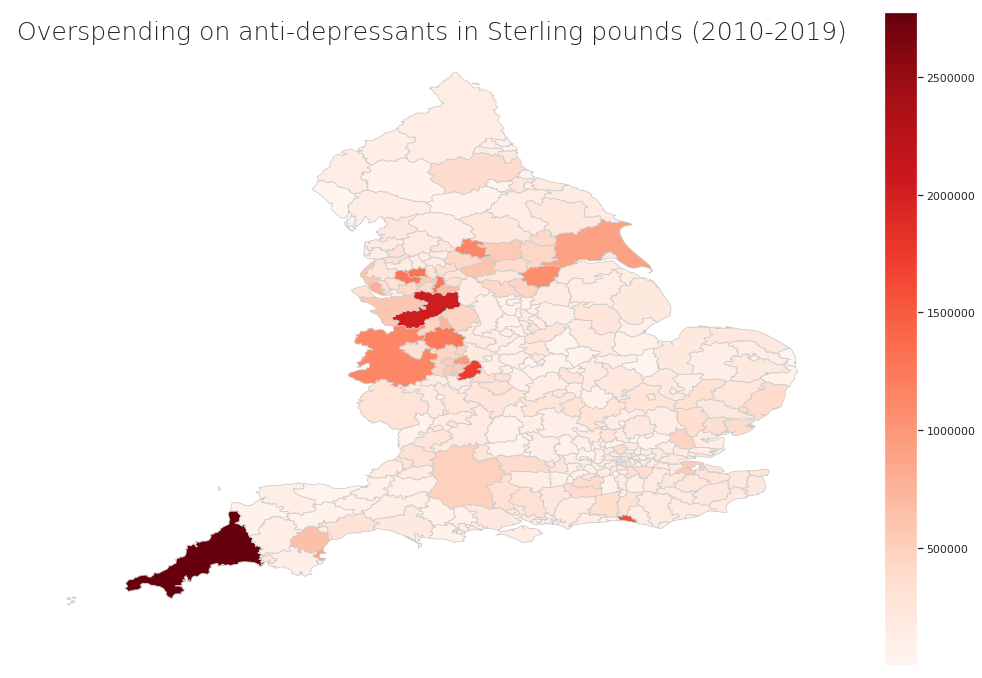

In [52]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Savings'
vmin, vmax = min(savings_df['Savings']) , max(savings_df['Savings'])

fig, ax = plt.subplots(1, figsize=(18, 12))
merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Overspending on anti-depressants in Sterling pounds (2010-2019)', fontdict={'fontsize': 25, 'fontweight' : 5})
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

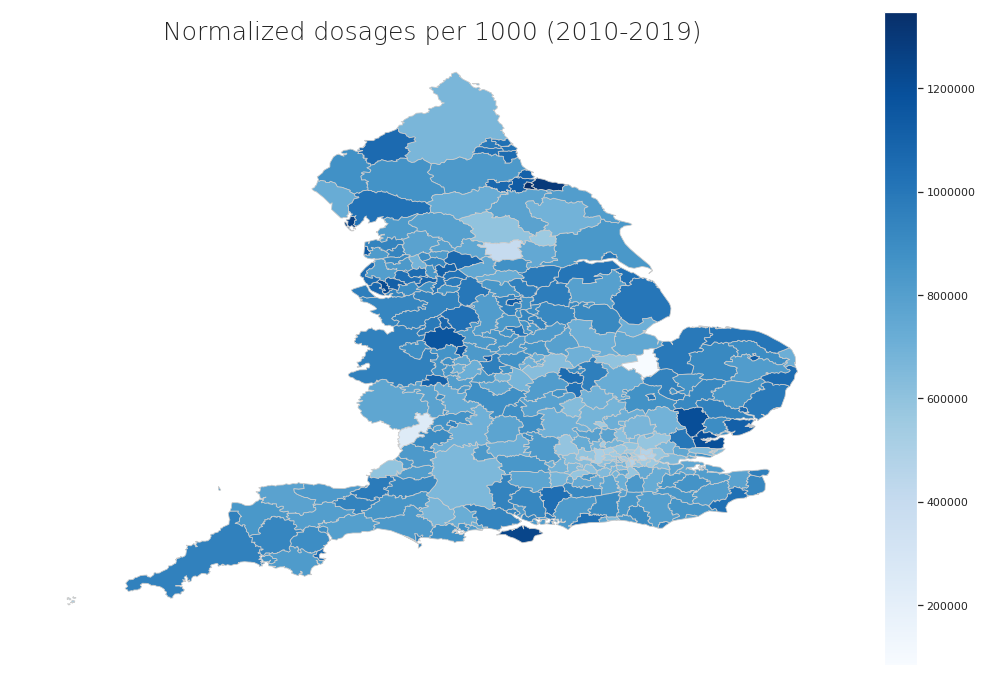

In [53]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Dosage'
vmin, vmax = min(savings_df['Dosage']) , max(savings_df['Dosage'])

fig, ax = plt.subplots(1, figsize=(18, 12))
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Normalized dosages per 1000 (2010-2019)', fontdict={'fontsize': 25, 'fontweight' : 5})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

In [54]:
standardized_merged = merged.copy()

In [55]:
def normalize(df,feature_names):
    result = df.copy()
    for feature_name in feature_names:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [56]:
standardized_merged = normalize(merged , ['Savings','Density','Dosage','IMD','Seniors'])

In [57]:
standardized_merged.head()

,objectid,lad17cd,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,Density,Dosage,IMD,Savings,Seniors,TotalCost
lad17nm,,,,,,,,,,,,,,,,
Hartlepool,1,E06000001,None,447157,531476,-1.27023,54.676159,9.658682e+07,50245.931523,POLYGON ((-1.243847684350774 54.72307842291248...,0.067302,0.812381,0.761571,0.018372,0.502048,22710.723439
Middlesbrough,2,E06000002,None,451141,516887,-1.21099,54.544670,5.474167e+07,35458.505804,POLYGON ((-1.200218340036424 54.58300135026919...,0.181541,1.000000,0.951849,0.035684,0.399775,25022.131748
Redcar and Cleveland,3,E06000003,None,464359,519597,-1.00611,54.567520,2.471405e+08,78666.802657,(POLYGON ((-1.200218311029187 54.5830013303063...,0.037741,0.960459,0.636909,0.072776,0.605706,27123.565424
Stockton-on-Tees,4,E06000004,None,444937,518183,-1.30669,54.556911,2.064738e+08,86947.340766,POLYGON ((-1.193937249483723 54.62987548771687...,0.065298,0.833872,0.530334,0.092298,0.453415,21171.210877
Darlington,5,E06000005,None,428029,515649,-1.56835,54.535351,1.982990e+08,91341.118700,POLYGON ((-1.439939711064031 54.59520822980085...,0.036621,0.784409,0.503677,0.014086,0.520818,19949.795658


In [58]:
corr = pearsonr(standardized_merged['Dosage'], standardized_merged['IMD'])

Text(0.8,0.2,'Corr: 0.20')

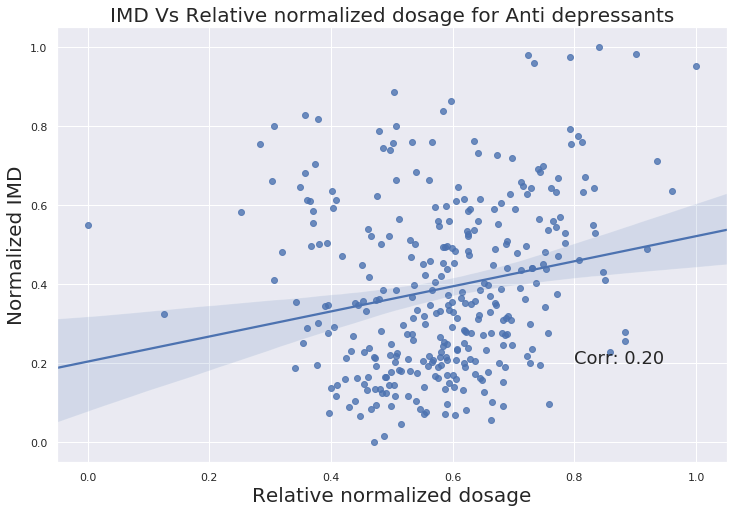

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Dosage',y='IMD',data=standardized_merged)
ax.set_title("IMD Vs Relative normalized dosage for Anti depressants" , fontsize=20)
ax.set_xlabel("Relative normalized dosage",fontsize=20)
ax.set_ylabel("Normalized IMD",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.2),fontsize = 18)


In [1]:
corr = pearsonr(standardized_merged['Savings'], standardized_merged['IMD'])

NameError: name 'pearsonr' is not defined

In [2]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Savings',y='IMD',data=standardized_merged)
ax.set_title("IMD Vs Overspending: Anti-depressants" , fontsize=20)
ax.set_xlabel("Normalized Overspending",fontsize=20)
ax.set_ylabel("Normalized IMD",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.2),fontsize = 18)


NameError: name 'plt' is not defined

In [64]:
corr = pearsonr(standardized_merged['Savings'], standardized_merged['Seniors'])

Text(0.8,0.2,'Corr: -0.0')

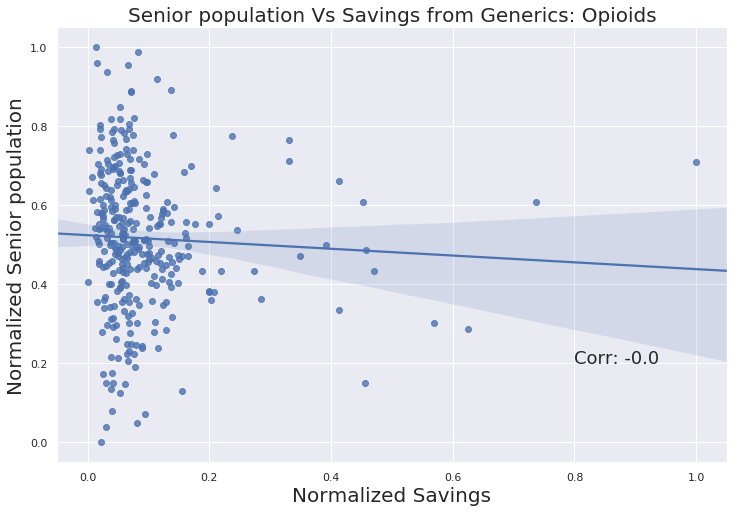

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Savings',y='Seniors',data=standardized_merged)
ax.set_title("Senior population Vs Savings from Generics: Opioids" , fontsize=20)
ax.set_xlabel("Normalized Savings",fontsize=20)
ax.set_ylabel("Normalized Senior population",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.2),fontsize = 18)

In [66]:
corr=pearsonr(standardized_merged['Savings'], standardized_merged['Density'])

Text(0.8,0.8,'Corr: -0.0')

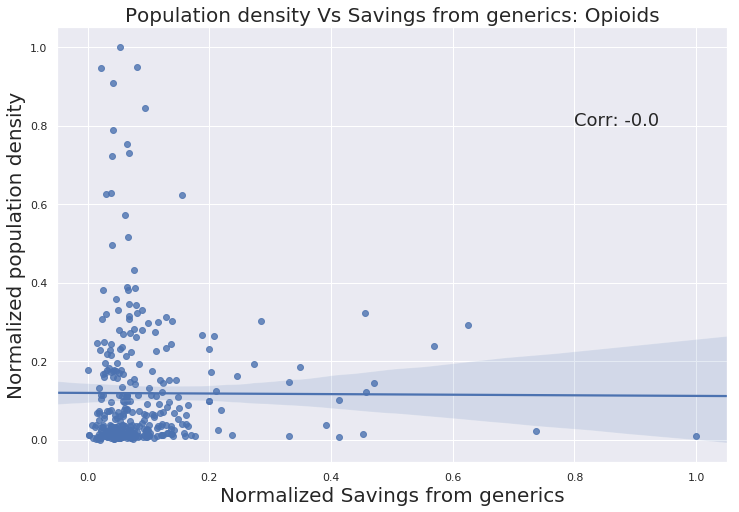

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Savings',y='Density',data=standardized_merged)
ax.set_title("Population density Vs Savings from generics: Opioids" ,fontsize=20)
ax.set_xlabel("Normalized Savings from generics",fontsize=20)
ax.set_ylabel("Normalized population density",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.8),fontsize = 18)

In [68]:
corr=pearsonr(standardized_merged['Dosage'], standardized_merged['Density'])

Text(0.8,0.8,'Corr: -0.3')

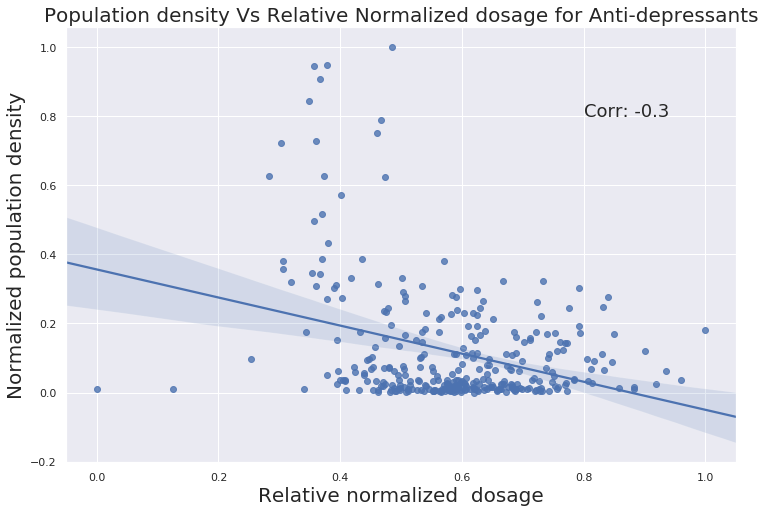

In [70]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Dosage',y='Density',data=standardized_merged)
ax.set_title("Population density Vs Relative Normalized dosage for Anti-depressants" ,fontsize=20)
ax.set_xlabel("Relative normalized  dosage",fontsize=20)
ax.set_ylabel("Normalized population density",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.8),fontsize = 18)


In [71]:
pearsonr(standardized_merged['Dosage'], standardized_merged['Seniors'])

(0.3369667276937599, 4.257557508129574e-10)

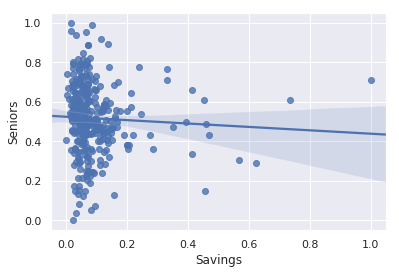

In [72]:
sns.regplot(x='Savings',y='Seniors',data=standardized_merged)

In [135]:
monthlySavings = {}
for k in monthly_borough_savings:
    monthlySavings[k] = np.median(monthly_borough_savings[k].values())
    
    
monthlyCosts = {}
for k in monthly_borough_costs:
    monthlyCosts[k] = np.median(monthly_borough_costs[k].values())

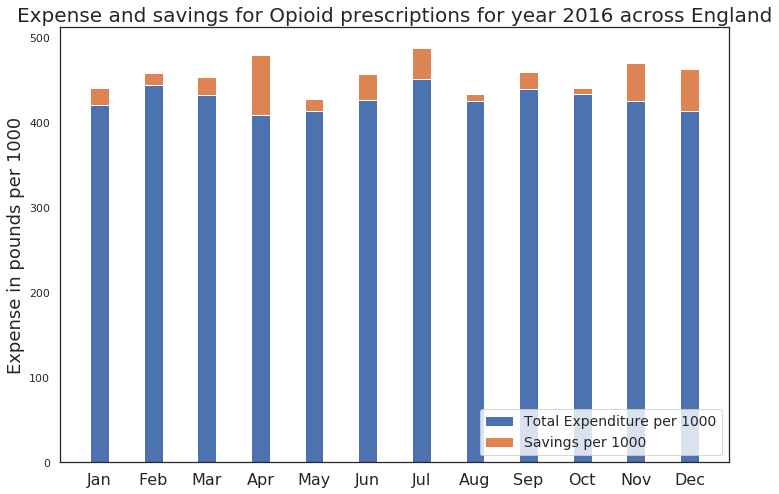

In [136]:
# libraries
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.set_style("white")
 
# Values of each group
saving = [monthlySavings[k] for k in monthlySavings]
total = [monthlyCosts[k] for k in monthlyCosts]
# print saving
# print total
# Heights of bars1 + bars2
bars = np.add(saving, total).tolist()
 
# The position of the bars on the x-axis
r = np.arange(0,len(total),1)
 
# Names of group and bar width
names = ['Jan' , 'Feb' , 'Mar', 'Apr' , 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct' , 'Nov', 'Dec']
width = 0.35  
 
p1 = plt.bar(r, total, width)
p2 = plt.bar(r, saving, width, bottom=total)

plt.ylabel(u'Expense in pounds per 1000' , fontsize = 18)
plt.title('Expense and savings for Opioid prescriptions for year 2016 across England' ,fontsize = 20 )
plt.xticks(r, names,fontsize = 16)
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Total Expenditure per 1000', 'Savings per 1000'),loc='lower right',fontsize = 14)

plt.show()
